In [150]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj

# ODE_PATH = '/home/wwj/Repo/projects/torchdiffeq/'
# sys.path.insert(0, ODE_PATH)
# sys.path.insert(0, '../..')

import torch
from torch.optim import Adam
from torchmd.system import PairPotentials
from torchmd.sovlers import odeint_adjoint, odeint
from torchmd.md import NoseHooverChain 

from nff.utils.scatter import compute_grad
from ase import Atoms
from math import sqrt

import torchmd

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False


In [3]:
DEVICE = 2
num_chains = 5

In [18]:
class Harmonic1D(torch.nn.Module):

    def __init__(self,  device=0,  adjoint=True):
        super().__init__()
        self.device = device
        self.adjoint = adjoint
        self.k = torch.nn.Parameter(torch.Tensor([1.0]))
        
    def potential(self, x):
        return 0.5 * self.k * x.pow(2)
        
    def forward(self, t, state):
        with torch.set_grad_enabled(True):        
            
            v = state[0]
            q = state[1]
            
            if self.adjoint:
                q.requires_grad = True
            
            u = self.potential(q)
            
            dqdt = v
            dvdt = -compute_grad(inputs=q, output=u.sum(-1)).reshape(-1)
            
        return dvdt, dqdt

In [59]:
from datetime import datetime
# test integration 

tau = 10
dt = 0.1
t_len = int( tau / dt )
t = torch.Tensor([dt * i for i in range(t_len)]).to(DEVICE)
t_np = t.detach().cpu().numpy()

In [20]:
q = torch.Tensor([1.0]).to(DEVICE) 
v = torch.Tensor([0.0]).to(DEVICE) #
q.requires_grad = True
v.requires_grad = True

In [103]:
def bencmark_time(method, adjoint=True, step_list=[]):
    
    duration_list = []
    
    
    for t_len in step_list:
        
        f_x = Harmonic1D(
                adjoint=adjoint).to(DEVICE)

        dt = 0.1
                
        t = torch.Tensor([dt * i for i in range(t_len)]).to(DEVICE)
        t_np = t.detach().cpu().numpy()

        # Initial condition 
        q = torch.Tensor([1.0]).to(DEVICE) # torch.empty(N, 1).normal_(mean=0,std=1).to(DEVICE)
        v = torch.Tensor([0.0]).to(DEVICE) # torch.empty(N, 1).normal_(mean=0,std=1).to(DEVICE)
        q.requires_grad = True
        v.requires_grad = True

        # verlet integration 
        time_stats = []
        for i in range(1):
            if adjoint:
                current_time = datetime.now() 
                v_v, q_v = odeint_adjoint(f_x, (v, q), t, method=method)
            else:
                current_time = datetime.now() 
                v_v, q_v = odeint(f_x, (v, q), t, method=method)

            loss = q_v.var()
            loss.backward()
            time = (datetime.now() - current_time).total_seconds()
            
            time_stats.append(time)
        
        duration_list.append(time_stats)
        
    return step_list, duration_list

In [92]:
def bencmark_grad(method, adjoint= True, dt_list =[0.05], steps_list=None):
    
    
    v_grad_list = []
    duration_list = []
    k_grad_list = []
    
    
    for dt in dt_list:
        
        f_x = Harmonic1D(
                adjoint=adjoint).to(DEVICE)

        tau = np.pi * 5/2
        t_len = int( tau / dt )
        
        t = torch.Tensor([dt * i for i in range(t_len)]).to(DEVICE)
        t_np = t.detach().cpu().numpy()

        # Initial condition 
        q = torch.Tensor([1.0]).to(DEVICE) # torch.empty(N, 1).normal_(mean=0,std=1).to(DEVICE)
        v = torch.Tensor([0.0]).to(DEVICE) # torch.empty(N, 1).normal_(mean=0,std=1).to(DEVICE)
        q.requires_grad = True
        v.requires_grad = True

        # verlet integration 
        current_time = datetime.now() 
        
        if adjoint:
            v_v, q_v = odeint_adjoint(f_x, (v, q), t, method=method)
        else:
            print(method)
            v_v, q_v = odeint(f_x, (v, q), t, method=method)

        loss = q_v.var()
        print(loss.item())
        #loss.backward()
        
        time = (datetime.now() - current_time).total_seconds()

        print(f_x.k.grad.item(), v.grad.item(), q.grad.item()) 
    
        k_grad_list.append(f_x.k.grad.item())
        v_grad_list.append(v.grad.item() )
        
        duration_list.append(time)
        
        plt.plot(q_v.detach().cpu().numpy())
        plt.plot(v_v.detach().cpu().numpy())
        plt.show()
        
    return dt_list, v_grad_list, duration_list

In [104]:
step_list = [ 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

In [105]:
step_list,  duration_verlet_ad = bencmark_time(method='verlet', adjoint=True, step_list=step_list)

step_list,  duration_verlet = bencmark_time(method='verlet', adjoint=False, step_list=step_list)

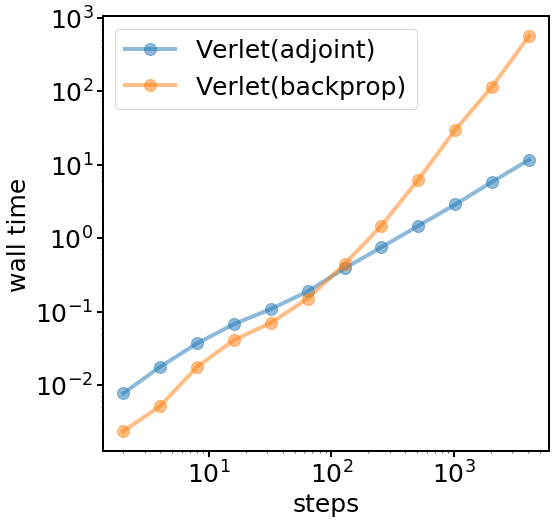

In [148]:

plt.figure(figsize=(8,8))
plt.plot(step_list, np.array(duration_verlet_ad).mean(-1) , label='Verlet(adjoint)',
         linewidth=4, alpha=0.5, marker='o', markersize=12)

#plt.errorbar(step_list, np.array(duration_verlet_ad).mean(-1), np.array(duration_verlet_ad).std(-1) ) 
plt.plot(step_list, np.array(duration_verlet).mean(-1) , label='Verlet(backprop)', 
         linewidth=4, alpha=0.5, marker='o', markersize=12)

#plt.errorbar(step_list, np.array(duration_verlet).mean(-1), np.array(duration_verlet).std(-1) ) 

plt.legend()
plt.xlabel("steps")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("wall time")
#plt.ylim(0.09, 0.12)
plt.show()

In [ ]:
# compute grad 

0.4841492772102356
-0.24088242650032043 0.09499253332614899 0.9683000445365906


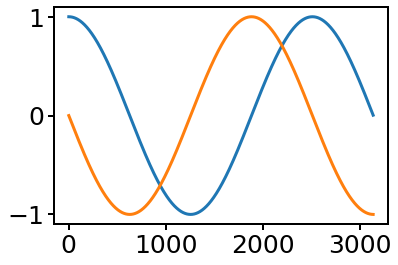

0.4845714867115021
-0.24813900887966156 0.09512922912836075 0.96914142370224


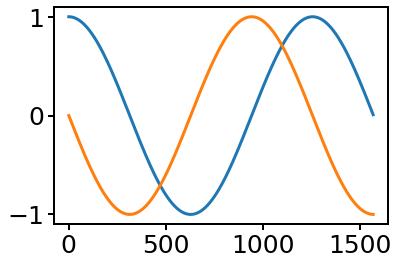

0.48511695861816406
-0.2619178295135498 0.09521900117397308 0.9702290892601013


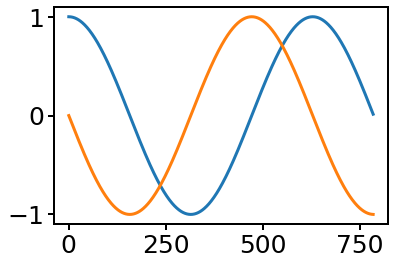

0.4867515563964844
-0.30347076058387756 0.09561508148908615 0.9734734296798706


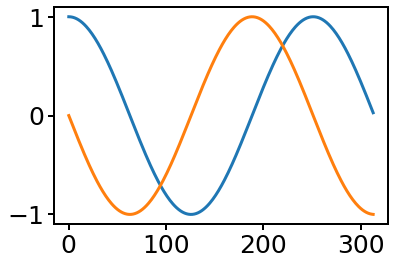

0.4894673824310303
-0.37344658374786377 0.09669902920722961 0.9788421988487244


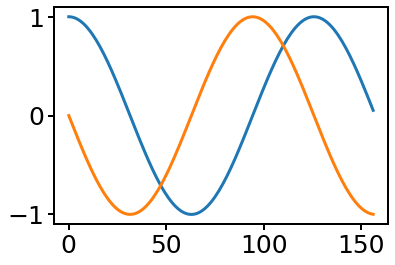

0.4980665445327759
-0.5222457051277161 0.10180513560771942 0.9959678649902344


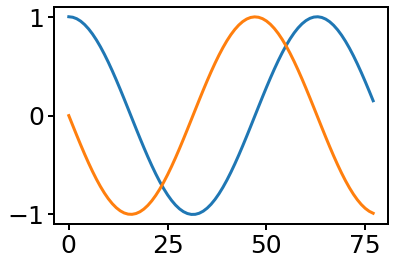

0.4841492772102356
-0.23422861099243164 0.09498979151248932 0.9682999849319458


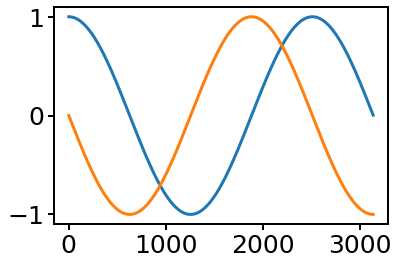

0.4845721125602722
-0.2348160445690155 0.09511838853359222 0.9691441655158997


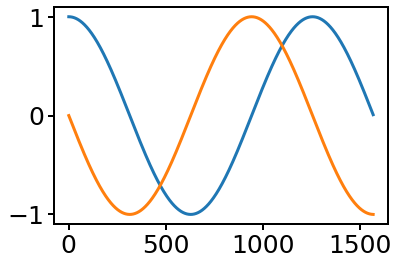

0.48511895537376404
-0.23523107171058655 0.09517505019903183 0.9702376127243042


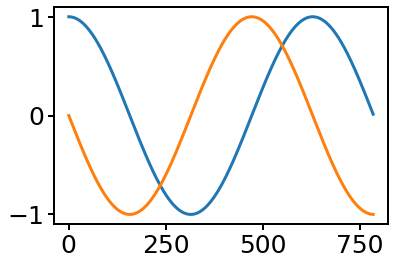

0.48676374554634094
-0.23646676540374756 0.09533665329217911 0.9735274910926819


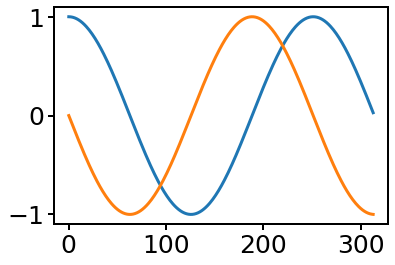

0.4895172119140625
-0.23848126828670502 0.095577672123909 0.9790346622467041


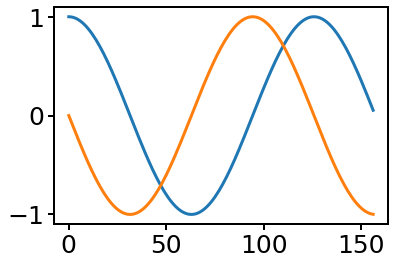

0.4982723295688629
-0.2466619610786438 0.09720387309789658 0.996545135974884


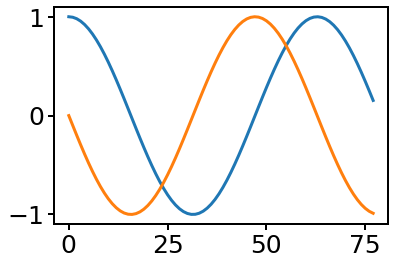

In [55]:
dt_list = [0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]

dt_range, v_grad_verlet_ad, duration_verlet_ad = bencmark(method='verlet',
                                                                    adjoint=True, dt_list=dt_list)

dt_range, v_grad_rk_ad, duration_rk_ad = bencmark(method='rk4', 
                                                            adjoint=True, dt_list=dt_list)


In [121]:
1/0.005

200.0

verlet
0.4841492772102356
-0.23422938585281372 0.09499116986989975 0.9683001637458801


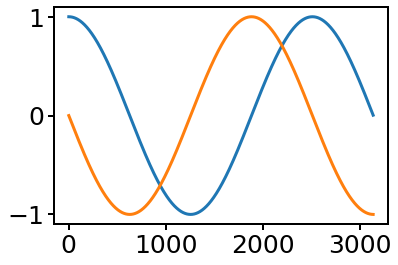

verlet
0.4845714867115021
-0.23481562733650208 0.09511946141719818 0.9691435098648071


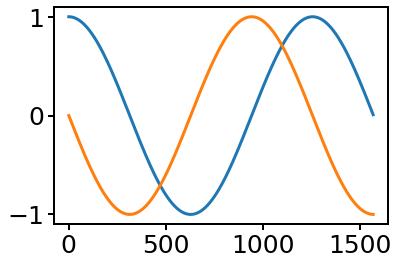

verlet
0.48511695861816406
-0.2352289855480194 0.09517478942871094 0.9702345132827759


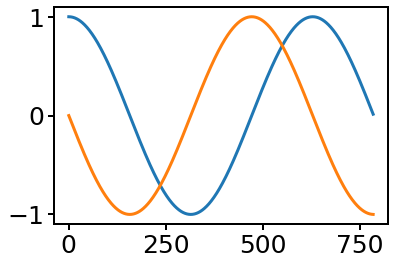

verlet
0.4867515563964844
-0.23644967377185822 0.09533611685037613 0.9735029339790344


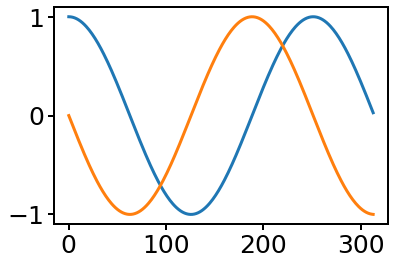

verlet
0.4894673824310303
-0.23842370510101318 0.09557877480983734 0.9789345860481262


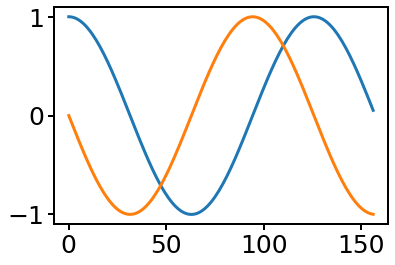

verlet
0.4980665445327759
-0.2466638833284378 0.09726091474294662 0.9961329698562622


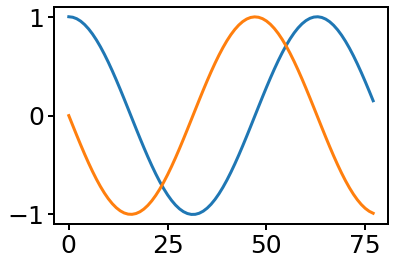

In [122]:
# dt_range, v_grad_rk, duration_rk = bencmark(method='rk4', adjoint=False,  
#                                              dt_list=dt_list)

dt_range, v_grad_v, duration_rk = bencmark(method='verlet', adjoint=False,  
                                             dt_list=dt_list)

In [94]:
v_grad_rk_ad

[147.39967346191406, 73.83306121826172, 37.04682922363281, 18.647994995117188]

In [163]:
dt_list

[0.0005, 0.001, 0.0025, 0.005, 0.0125, 0.025, 0.05, 0.1]

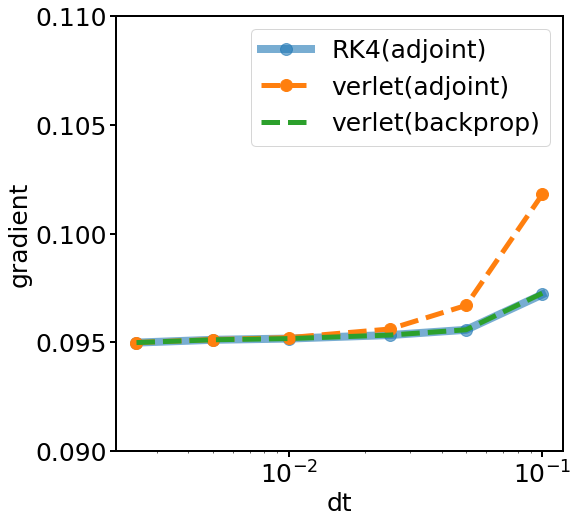

In [145]:
# nsteps = 1/ np.array(dt_list)
# nsteps_noad = 1/ np.array(dt_range_noad)
#plt.plot(dt_range, v_grad_rk)
plt.figure(figsize=(8,8))
plt.plot(dt_list, np.array(v_grad_rk_ad) , label='RK4(adjoint)', linewidth=8, alpha=0.6,
        marker='o', markersize=12)
#plt.plot(dt_range_noad, np.array(k_grad_rk) , label='RK4(brute-force)', linewidth=5,  linestyle='--')
plt.plot(dt_list, np.array(v_grad_verlet_ad) , label='verlet(adjoint)', linewidth=5,  linestyle='--',
        marker='o', markersize=12)

plt.plot(dt_list, np.array(v_grad_v) , label='verlet(backprop)', linewidth=5,  linestyle='--')
#plt.plot(dt_range_noad, np.array(k_grad_verlet) , label='verlet(brute-force)', linewidth=8, 
#         linestyle=':' ,alpha=0.8)
plt.legend()
plt.xlabel("dt")
plt.xscale("log")
plt.ylabel("gradient")
plt.ylim(0.09, 0.11)
plt.show()

In [139]:
nsteps_noad

array([200.,  80.,  40.,  20.,  10.])

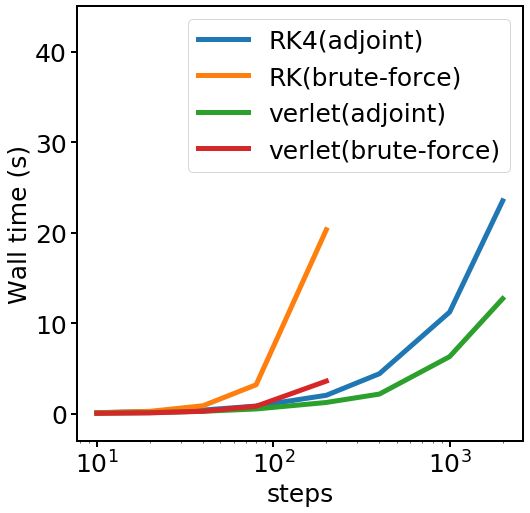

In [162]:
#plt.plot(nsteps, duration_rk)
plt.figure(figsize=(8,8))

plt.plot(nsteps, duration_rk_ad, label='RK4(adjoint)', linewidth=5)
plt.plot(nsteps_noad, duration_rk, label='RK4(brute-force)', linewidth=5)
plt.plot(nsteps, duration_verlet_ad, label='verlet(adjoint)', linewidth=5)
plt.plot(nsteps_noad, duration_verlet, label='verlet(brute-force)', linewidth=5)

plt.xlabel("steps")
plt.ylabel("Wall time (s)")
plt.xscale("log")
plt.legend()
plt.ylim(-3, 45)

plt.show()

In [412]:
%%time
q_v.sum().backward()

CPU times: user 818 ms, sys: 15.6 ms, total: 834 ms
Wall time: 822 ms


In [550]:
%%time
q_r.sum().backward()

CPU times: user 245 ms, sys: 0 ns, total: 245 ms
Wall time: 244 ms


In [ ]:
current_time = datetime.now() 

In [512]:
time = [100, 200, 400]
cost_v = [1.02, 3.43, 13.8]
cost_r = [3.78, 14,  70]

cost_v_total = 

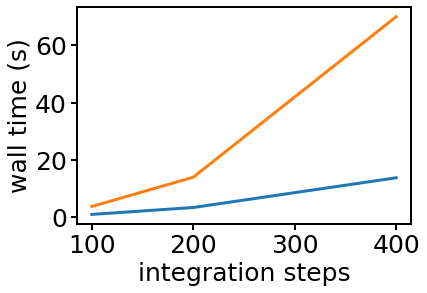

In [530]:
plt.plot(time, cost_v)
plt.plot(time, cost_r)
plt.ylabel("wall time (s)")
plt.xlabel("integration steps")
plt.show()

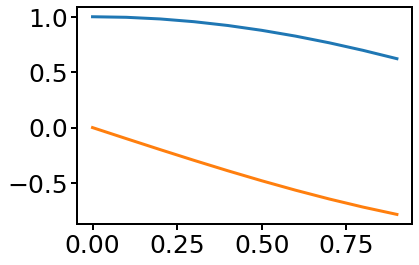

In [536]:
plt.plot(t_np, q_v.detach().cpu().numpy().reshape(-1), label='q')
plt.plot(t_np, v_v.detach().cpu().numpy().reshape(-1), label='p')
#plt.plot(t_np, E_v.squeeze().detach().cpu().numpy(), label='E')
#plt.legend()
plt.show()

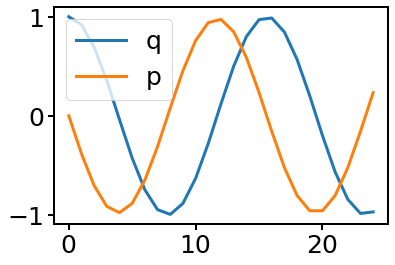

In [164]:
plt.plot(q_v.detach().cpu().numpy().reshape(-1), label='q')
plt.plot(v_v.detach().cpu().numpy().reshape(-1), label='p')
#plt.plot(E_r.squeeze().detach().cpu().numpy(), label='E')
plt.legend()
plt.show()

In [282]:
q_dt#.detach()#.cpu()#.numpy()#.reshape(-1)

tensor([[2.4557]], device='cuda:1', grad_fn=<AddBackward0>)

In [173]:
q.grad

tensor([[2.9999]], device='cuda:1')